- 샘플로 21,22, 23년도만 시행

In [1]:
# Library
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from konlpy.tag import Okt

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from networkx.algorithms.community import greedy_modularity_communities
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [2]:
t = pd.read_csv('./Data/Preprocess_Data/Abstract3.csv')
words_data = pd.read_csv('./Data/Preprocess_Data/final_words.csv')

In [7]:
t2 = t[t['Year']>=2014]

In [3]:
words_data.head()

,word,word2,length
0,bidirectional encoder representations from tra...,bidirectional_encoder_representations_from_tra...,55
1,bidirectional encoder representations from tra...,bidirectional_encoder_representations_from_tra...,54
2,deep convolutional generative adversarial network,deep_convolutional_generative_adversarial_network,49
3,contrast limited adaptive histogram equalization,contrast_limited_adaptive_histogram_equalization,48
4,covariance matrix adaptation evolution strategy,covariance_matrix_adaptation_evolution_strategy,47


- 단어전처리는 이미 되서 패스

In [7]:
words_data = words_data[words_data['제거']!='x']
words_data.reset_index(drop=True, inplace=True)
words_data.drop('제거',axis=1, inplace=True)
len(words_data)

9187

In [89]:
# 양쪽 공백 제거
words_data['word'] = words_data['word'].str.strip()

In [90]:
# words_data에 공백을 언더바(_)로 대체
words_data['word2'] = 0
for i in range(len(words_data)):
    if len(str(words_data['word'][i]).split(' ')) >1:
        words_data['word2'][i] = words_data['word'][i].replace(' ','_')
    else:
        words_data['word2'][i] = words_data['word'][i]

In [91]:
words_data['length'] = 0
for i in range(len(words_data)):
    words_data['length'][i] = len(str(words_data['word'][i]))

In [92]:
# length에 따라 정렬 (변환이 제대로 되지 않는 것 방지)
words_data.sort_values(by='length', ascending=False, inplace=True)
words_data.reset_index(drop=True, inplace=True)
words_data.head()

,word,count,word2,length
0,bidirectional encoder representations from tra...,24,bidirectional_encoder_representations_from_tra...,54
1,deep convolutional generative adversarial network,31,deep_convolutional_generative_adversarial_network,49
2,contrast limited adaptive histogram equalization,32,contrast_limited_adaptive_histogram_equalization,48
3,covariance matrix adaptation evolution strategy,25,covariance_matrix_adaptation_evolution_strategy,47
4,ciphertext policy attribute based encryption,69,ciphertext_policy_attribute_based_encryption,44


In [93]:
# 중복되는 값 중 첫번째만 남기고 제거
words_data.drop_duplicates(subset='word2', keep='first', inplace=True)

In [94]:
len(words_data)

9155

In [5]:
t.head()

,Unnamed: 0,Year,Abstract3
0,0,2013,a method for peer to peer streaming of video o...
1,1,2013,in this paper we discus the bacterial network ...
2,2,2013,this article treat a digital humanity work in ...
3,3,2013,this work describes preliminary step towards n...
4,4,2013,goal extraction in learning by demonstration i...


In [8]:
t2.head()

,Unnamed: 0,Year,Abstract3
38385,38385,2017,the qrs complex detection method have been ext...
38386,38386,2017,in this paper we study the problem of moving_t...
38387,38387,2017,objective using the fusion algorithm of edge_d...
38388,38388,2017,in view of the special condition of gas draina...
38389,38389,2017,this paper propose a trajectory tracking contr...


# 워드투벡

In [9]:
t2['tokens2'] = t2['Abstract3'].apply(lambda x: [word for word in word_tokenize(x)])
sentences = t2['tokens2'].tolist()

In [98]:
'game_ais' in sentences

False

In [10]:
# Word2Vec 모델 학습
model = Word2Vec(sentences, min_count=1)

# 단어 벡터 확인
word_vectors = model.wv

In [11]:
# 결과 저장
model.save("notyear_w2v.model")

# 해당되는 단어들만 남기기

In [12]:
# list 칼럼의 단어들을 분리하여 리스트로 변환
word_lists = t2['Abstract3'].str.split()

In [13]:
word_lists

38385      [the, qrs, complex, detection, method, have, b...
38386      [in, this, paper, we, study, the, problem, of,...
38387      [objective, using, the, fusion, algorithm, of,...
38388      [in, view, of, the, special, condition, of, ga...
38389      [this, paper, propose, a, trajectory, tracking...
                                 ...                        
2267158    [human, centered, development, of, information...
2267159    [the, computing, device, in, cloud, or, fog, d...
2267160    [mobile, technology, are, becoming, more, and,...
2267161    [development, of, intelligent, system, with, t...
2267162    [in, this, paper, we, gauge, the, utility, of,...
Name: Abstract3, Length: 1275504, dtype: object

In [14]:
# 단어 집합을 집합(Set)으로 변환하여 탐색 시간을 단축
words_subset = set(words_data['word2'])

In [15]:
len(words_subset)

9121

In [104]:
'game_ais' in words_subset

False

- 여기까지는 코드 돌리는데 이상 없음

In [16]:
# 정규식 패턴을 미리 생성하여 반복문 내에서 재사용
pattern = re.compile(r'\b({})\b'.format('|'.join(map(re.escape, words_subset))))

In [17]:
new_word_lists = []

for words in tqdm(word_lists, total=len(t2)):
    new_words = []
    for word in words:
        if pattern.match(word):
            new_words.append(word)
    new_word_lists.append(new_words)

100%|██████████████████████████████| 1275504/1275504 [2:06:07<00:00, 168.55it/s]


In [18]:
new_word_strings = [' '.join(word_list) for word_list in new_word_lists]

In [105]:
'game_ais' in new_word_strings

False

In [19]:
t2['new_abstract'] = new_word_strings

In [20]:
t2['new_abstract']

38385                                                       
38386      moving_target_detection target_detection backg...
38387      edge_detection canny sobel edge_information mi...
38388               control image_transmission demonstration
38389      control_method backstepping control_system att...
                                 ...                        
2267158    concept aspect enterprise_architecture enterpr...
2267159    cloud data_center cooling_system data_center c...
2267160                                                     
2267161    abnormal_event degradation anomaly_detection a...
2267162         combining approach computational_linguistics
Name: new_abstract, Length: 1275504, dtype: object

In [21]:
# 불용어 제거

t2['new_abstract'] = t2['new_abstract'].astype(str)
# new_abstract 칼럼에서 words_subset에 있는 단어들만 남기기
t2['new_abstract2'] = t2['new_abstract'].apply(lambda x: ' '.join([word for word in x.split() if word in words_subset]))

In [ ]:
words_subset안에 있는 단어만 남기기

In [130]:
t2['new_abstract2'][0]

'automation facility automation drone calibration mobile_robot calibration thermal_camera lidar calibration pose_estimation'

In [22]:
replacement_dict = {
    'ada_boost': 'adaboost',
    'zig_bee': 'zigbee',
    'optimisation': 'optimization',
    'neural_networks': 'neural_network',
    'audiovisual': 'audio_visual',
    'authorisation': 'authorization',
    'chatbots': 'chatbot',
    'conceptualisation': 'conceptualization'
}

def replace_words(text):
    for old_word, new_word in replacement_dict.items():
        text = text.replace(old_word, new_word)
    return text

tqdm.pandas()  # tqdm을 사용하기 위해 pandas에 연결

t2['new_abstract2'] = t2['new_abstract2'].progress_apply(replace_words)

100%|█████████████████████████████| 1275504/1275504 [00:02<00:00, 577802.70it/s]


In [132]:
model.wv.most_similar('machine_learning', topn=20)

[('deep_learning', 0.8397312164306641),
 ('ml', 0.838851809501648),
 ('data_mining', 0.7515307068824768),
 ('machine_learning_technique', 0.7492014169692993),
 ('natural_language_processing', 0.7145198583602905),
 ('artificial_intelligence', 0.7053048610687256),
 ('ml/dl', 0.6955404877662659),
 ('dl', 0.6886632442474365),
 ('nlp', 0.6710163354873657),
 ('machine_learning_method', 0.6675263047218323),
 ('explainable_artificial_intelligence', 0.6571083664894104),
 ('computer_vision', 0.6511135697364807),
 ('deep_neural_network', 0.6508054733276367),
 ('artificial_neural_network', 0.6431666612625122),
 ('ai', 0.6407159566879272),
 ('machine_learning_approach', 0.6396990418434143),
 ('explainable_ai', 0.6375511288642883),
 ('ai/ml', 0.6264525651931763),
 ('data_science', 0.6250278353691101),
 ('automated_machine_learning', 0.6075279712677002)]

# 그리디 알고리즘

### (1) 코사인 유사도

In [23]:
t2.head()

,Unnamed: 0,Year,Abstract3,tokens2,new_abstract,new_abstract2
38385,38385,2017,the qrs complex detection method have been ext...,"[the, qrs, complex, detection, method, have, b...",,
38386,38386,2017,in this paper we study the problem of moving_t...,"[in, this, paper, we, study, the, problem, of,...",moving_target_detection target_detection backg...,moving_target_detection target_detection backg...
38387,38387,2017,objective using the fusion algorithm of edge_d...,"[objective, using, the, fusion, algorithm, of,...",edge_detection canny sobel edge_information mi...,edge_detection canny sobel edge_information mi...
38388,38388,2017,in view of the special condition of gas draina...,"[in, view, of, the, special, condition, of, ga...",control image_transmission demonstration,control image_transmission demonstration
38389,38389,2017,this paper propose a trajectory tracking contr...,"[this, paper, propose, a, trajectory, tracking...",control_method backstepping control_system att...,control_method backstepping control_system att...


In [24]:
t2.drop(['Unnamed: 0'],axis=1, inplace=True)

In [25]:
t2.head(2)

,Year,Abstract3,tokens2,new_abstract,new_abstract2
38385,2017,the qrs complex detection method have been ext...,"[the, qrs, complex, detection, method, have, b...",,
38386,2017,in this paper we study the problem of moving_t...,"[in, this, paper, we, study, the, problem, of,...",moving_target_detection target_detection backg...,moving_target_detection target_detection backg...


In [26]:
t2['tokens2'] = t2['new_abstract2'].astype(str).apply(lambda x: word_tokenize(x))
t2['tokens2'] = t2['tokens2'].apply(lambda tokens: [token for token in tokens if token != ','])

In [27]:
sentences = t2['tokens2'].tolist()
sentences = [sentence for sentence in tqdm(sentences, desc="Processing sentences")]

Processing sentences: 100%|██████| 1275504/1275504 [00:00<00:00, 3657580.48it/s]


In [28]:
sentences_flat = [word for sentence in sentences for word in sentence]
sentences_flat = list(set(sentences_flat))

In [29]:
len(sentences_flat)

9025

In [30]:
# 주어진 단어들에 대한 Word2Vec 결과 벡터 추출
word_vecs = [word_vectors[word] for word in sentences_flat]
# 모든 단어 쌍의 코사인 유사도 계산
similarity_matrix = cosine_similarity(word_vecs)

# 대각선을 0으로 설정
np.fill_diagonal(similarity_matrix, 0)


# 결과를 DataFrame으로 변환
similarity_df = pd.DataFrame(similarity_matrix, index=sentences_flat, columns=sentences_flat)

In [31]:
threshold = 0.5

above_threshold = np.sum(similarity_matrix >= threshold)
total_elements = np.prod(similarity_matrix.shape)
ratio = above_threshold / total_elements

print(f"Ratio above threshold ({threshold}): {ratio}")

Ratio above threshold (0.5): 0.011045022674779966


### (2) 그리디 알고리즘

In [32]:
# 유사성 임계값 설정
similarity_threshold = 0.5

# 그래프 생성
G = nx.Graph()

# 논문 추가
for i in tqdm(range(len(sentences_flat)), desc="Adding Nodes"):
    G.add_node(sentences_flat[i])

# 엣지 추가 (유사성 임계값 이상인 경우만)
for i in tqdm(range(len(sentences_flat)), desc="Adding Edges"):
    for j in range(i+1, len(sentences_flat)):
        similarity = similarity_matrix[i, j]
        if similarity > similarity_threshold:
            G.add_edge(sentences_flat[i], sentences_flat[j], weight=similarity)

Adding Edges: 100%|████████████████████████| 9025/9025 [00:58<00:00, 154.60it/s]


In [33]:
# 커뮤니티 탐색
min_community_size = 2  # 최소 커뮤니티 크기 설정
communities = [c for c in greedy_modularity_communities(G, weight='weight') if len(c) >= min_community_size]

# 결과 출력
print("커뮤니티 수:", len(communities))

커뮤니티 수: 14


In [34]:
# 각 커뮤니티의 중심점 찾기
centroids = []
for community in tqdm(communities, desc="Finding Centroids"):
    community_vectors = [word_vectors[word] for word in community if word in word_vectors]
    if len(community_vectors) > 0:
        community_centroid = sum(community_vectors) / len(community_vectors)
        centroids.append(community_centroid)

Finding Centroids: 100%|████████████████████████| 14/14 [00:00<00:00, 15.61it/s]


In [35]:
G_centroids = nx.Graph()
for i in range(len(centroids)):
    for j in range(i + 1, len(centroids)):
        centroid_i = centroids[i]
        centroid_j = centroids[j]
        similarity = cosine_similarity([centroid_i], [centroid_j])[0][0]
        if similarity > similarity_threshold:
            G_centroids.add_edge(f"Centroid {i+1}", f"Centroid {j+1}", weight=similarity)

In [36]:
G_edges = G_centroids.edges(data=True)
for edge in G_edges:
    node1, node2, weight = edge
    print(f"{node1} -- {node2} (Similarity: {weight['weight']})")

In [37]:
import pandas as pd

# 데이터프레임 생성
community_df = pd.DataFrame(columns=['Word', 'Community'])

# 커뮤니티 정보 추가
for i, community in enumerate(communities):
    for word in community:
        community_df = community_df.append({'Word': word, 'Community': f"Community {i+1}"}, ignore_index=True)


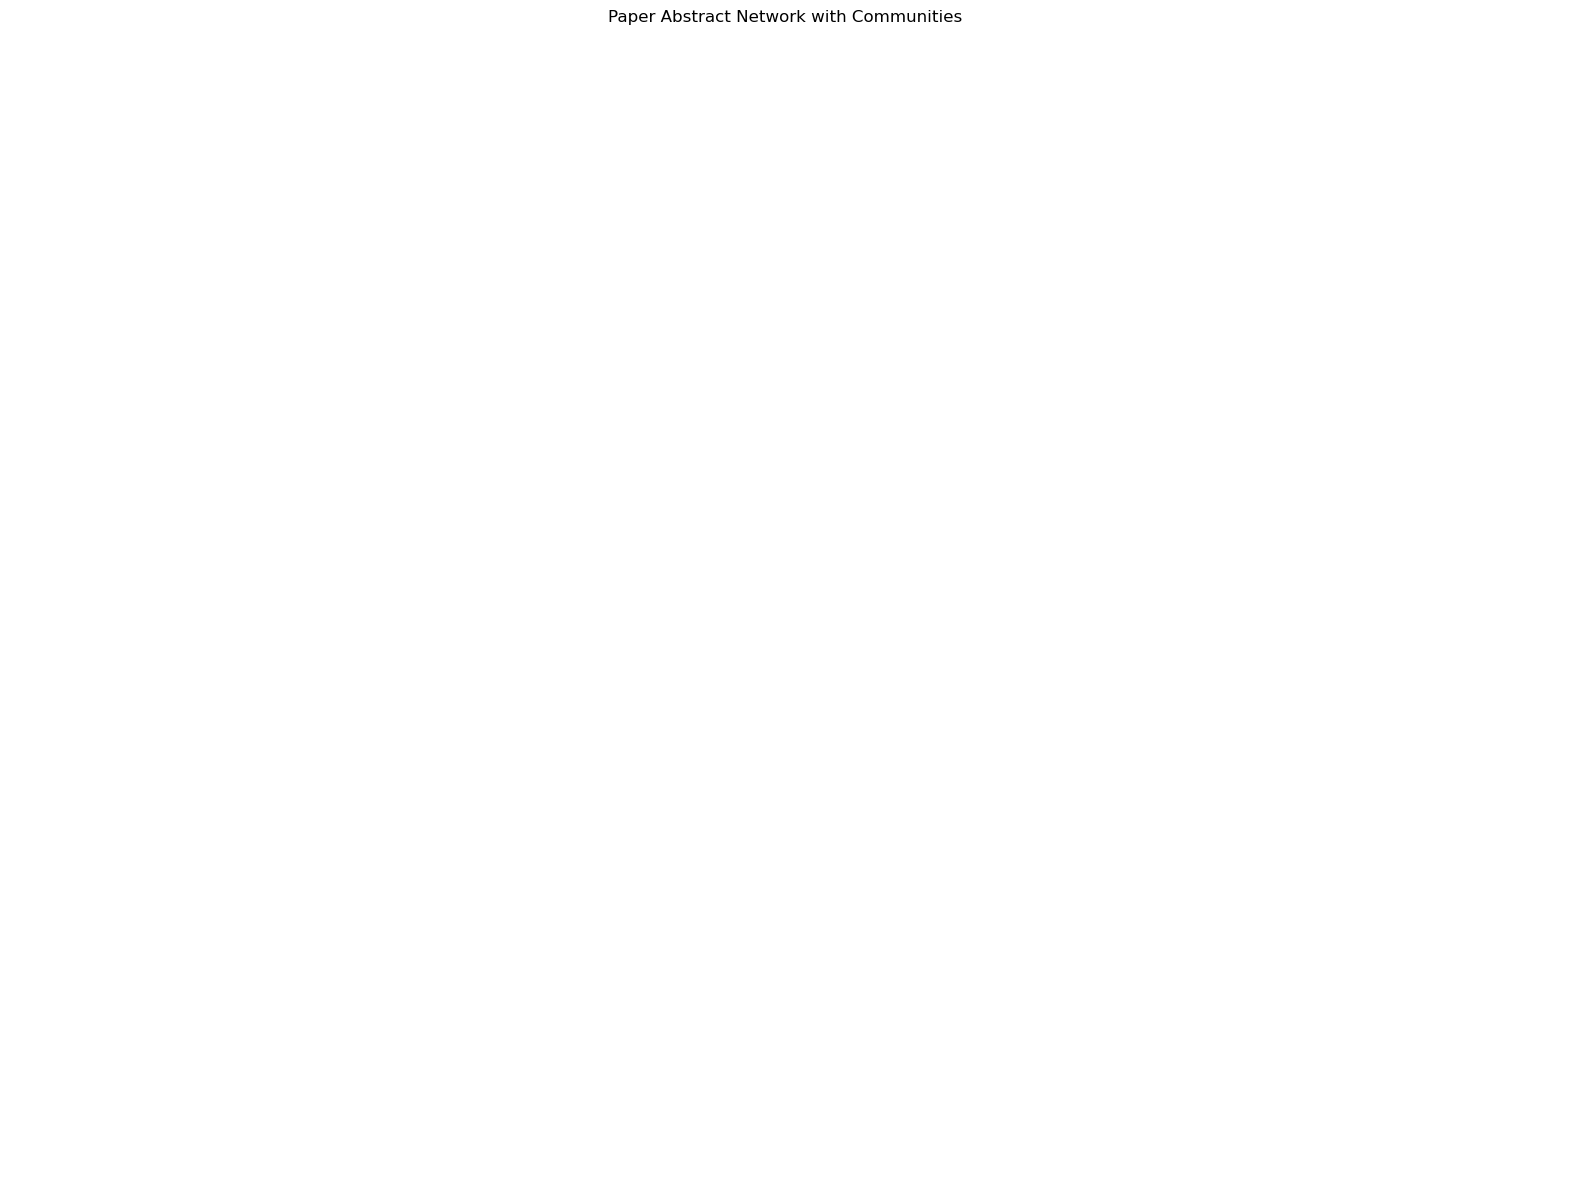

In [38]:
# 그래프 그리기
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 15))
nx.draw(G_centroids, with_labels=True, ax=ax)
plt.title('Paper Abstract Network with Communities')
plt.show()

In [39]:
community_df.to_csv('연도안붙이고그리디.csv',encoding='utf-8-sig', index=False)

In [40]:
community_df['Community'].value_counts()

Community 1     4394
Community 2     3000
Community 3     1092
Community 4      250
Community 5      182
Community 6        3
Community 7        2
Community 8        2
Community 9        2
Community 10       2
Community 11       2
Community 12       2
Community 13       2
Community 14       2
Name: Community, dtype: int64

### (3) Affinity Clustering

In [41]:
n = len(community_df)
standard = n*(n-1)/2*0.015

similarity_array = similarity_matrix.flatten()
# similarity_array 정렬
sorted_indices = np.argsort(-similarity_array)
sorted_similarity = similarity_array[sorted_indices]
print(sorted_similarity[int(standard)])

0.5345594


In [42]:
words = list(community_df['Word'])

In [43]:
# 선택된 단어 벡터를 numpy 배열로 변환합니다.
word_vectors_np = np.array([model.wv[word] for word in words])

In [45]:
# AffinityPropagation 알고리즘을 사용하여 클러스터링을 수행합니다.
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(damping=0.7)
af.fit(word_vectors_np)

# 각 단어를 해당하는 클러스터에 할당합니다.
word_clusters = {word: af.predict([model.wv[word]])[0] for word in words}

n_clusters = len(af.cluster_centers_indices_)
print('Estimated number of clusters: %d' % n_clusters)

Estimated number of clusters: 1521


In [ ]:
# 데이터프레임 생성
df_clusters = pd.DataFrame({'Word': words, 'Cluster': list(word_clusters.values())})

In [ ]:
df_clusters['Cluster'].value_counts()

In [ ]:
t2 = t2[['Year','Abstract3','new_abstract2']]

In [ ]:
t2.head()

In [ ]:
t2.to_csv('연도안붙인abstracts.csv', encoding='utf-8-sig')